## Redis Cache with MongoDB


           


#### This part of the project is a caching and rate-limiting system designed to enhance the performance and reliability of accessing merchant data stored in a MongoDB database. It utilizes Redis as a caching mechanism to store frequently accessed data and implements rate limiting to prevent excessive requests. The system monitors changes in the MongoDB database and updates the cache accordingly, ensuring that the cached data remains consistent with the database. By combining caching with rate limiting, the project aims to optimize the retrieval of customer data while mitigating the risk of overwhelming the database with excessive requests.

 When running the provided code, there are several functionalities you can try and experiment with to understand its behavior and test its functionality.

Testing Rate Limiting:

Execute the code more than 5 times within a minute and observe if the rate limiting functionality works as expected. After the 5th execution, the code should return a rate limit exceeded error.

Cache Expiry Testing:

Set the expiration time of the cache to a shorter period and observe how quickly the cached data expires. You can modify the set_data_to_redis_with_expiry function to set a shorter expiry time, and then fetch the data multiple times to see when it expires and gets fetched from MongoDB again.

Database Change Monitoring:

Introduce changes in the MongoDB database while the program is running and observe how the cache invalidation process works. You can manually insert/update/delete documents in the MongoDB 'customers' collection and see if the cache gets invalidated accordingly.

Additional Features:

We can extend the functionality by adding features such as authentication, data validation, pagination, or additional caching strategies (e.g., caching at different levels, like at the application level or using a distributed cache).
By experimenting with these functionalities, we can gain a better understanding of how the code works and how it behaves under different scenarios, helping you identify and address any potential issues or areas for improvement.

#### These lines import necessary libraries and modules such as time, json, pymongo (MongoDB driver), redis (Redis client), functools, ratelimit (for rate limiting), and bson (Binary JSON) from pymongo.


In [1]:
import csv
import json
import time
import threading
import functools
from ratelimit import limits, RateLimitException
from bson import json_util
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import pymongo
import redis

#### This section initializes connections to MongoDB and Redis, and specifies the database and collection to be used.

In [2]:
# MongoDB and Redis setup.
client = pymongo.MongoClient('mongodb://mongodb:27017/') 
redis_client = redis.StrictRedis(host='redis', port=6379, db=0) 
db = client['shaunakdatabase']
collection_name = 'customers'

#### This function inserts data into the MongoDB collection.


In [3]:
def insert_data_to_mongodb(data: list) -> None:
    """
    Inserts data into the MongoDB collection.

    :param data: A list of dictionaries representing the data to be inserted into the MongoDB collection.
    :return: None.
    """
    db[collection_name].insert_many(data)


#### This is a decorator function that applies rate limiting to other functions. It wraps the decorated function and limits the number of calls within a specified period.

In [4]:
def rate_limited(max_calls: int = 5, period: int = 60) -> callable:
    """
    Decorator to enforce rate limiting on a function.

    This decorator limits the number of calls to a function 
    within a specified time period.

    :param max_calls: The maximum number of calls allowed within the specified period.
    :param period: The time period (in seconds) within which the maximum number of calls is allowed.
    :return: Decorator function to enforce rate limiting.
    """
    def decorator(func: callable) -> callable:
        """
        Decorator function returned by rate_limited decorator.

        This decorator function takes another function as input and 
        returns a new function that enforces rate limiting on it.

        :param func: The function to be decorated.
        :return: Wrapped function enforcing rate limiting.
        """
        @functools.wraps(func)
        @limits(calls=max_calls, period=period)
        def wrapper(*args, **kwargs) -> callable:
            """
            Wrapper function enforcing rate limiting.

            This wrapper function intercepts calls to the decorated function, 
            checks if the rate limit has been exceeded,and either executes
            the function or returns an error message accordingly.

            :param args: Positional arguments passed to the decorated function.
            :param kwargs: Keyword arguments passed to the decorated function.
            :return: Result of the decorated function or an error message if rate limit is exceeded.
            """
            try:
                return func(*args, **kwargs)
            except RateLimitException as e:
                print("Too many calls. Please try again later.")
                return {"error": "Rate limit exceeded. Please try again later."}, 429
        return wrapper
    return decorator

#### This function sets data to Redis with an expiration time (expiry_seconds). It is used to cache data retrieved from MongoDB with a specified expiry time.

In [5]:
def set_data_to_redis_with_expiry(key: str, data: str, expiry_seconds: int) -> None:
    """
    Sets data in Redis cache with an expiration time.

    This function sets data in the Redis cache with an 
    expiration time specified in seconds.

    :param key: The key under which the data will be stored in Redis.
    :param data: The data to be stored.
    :param expiry_seconds: The expiration time for the data (in seconds).
    :return: None
    """
    redis_client.setex(key, expiry_seconds, data)


#### The below functions invalidates cache by deleting data associated with a given merchant_id from Redis. It is used to remove outdated data from the cache. It also monitors changes in the MongoDB database. It retrieves the most recent timestamp of the last change processed from Redis, queries the database for changes since that timestamp, and updates the cache accordingly.

In [6]:
def invalidate_cache(merchant_id: str) -> None:
    """
    Invalidates the cache for a given merchant ID.

    This function invalidates the cache entry associated 
    with the given merchant ID in the Redis cache.

    :param merchant_id: The ID of the merchant whose cache is to be invalidated.
    :return: None.
    """
    redis_client.delete(merchant_id)


In [7]:
def monitor_database_changes() -> None:
    """
    Monitors database changes and invalidates cache accordingly.
    
    :return: None.
    """
    while True:
        try:
            # Retrieve the most recent timestamp of the last change processed.
            last_change_timestamp = redis_client.get('last_change_timestamp')
            if last_change_timestamp is None:
                last_change_timestamp = 0
            else:
                last_change_timestamp = float(last_change_timestamp)
            
            # Query the database for changes since the last processed change.
            changes = db[collection_name].find(
                {'timestamp': {'$gt': last_change_timestamp}}
            ).sort([('timestamp', pymongo.ASCENDING)])
            
            # Count the number of changes.
            num_changes = db[collection_name].count_documents({'timestamp': {'$gt': last_change_timestamp}})
            
            # Process each change and invalidate cache.
            for change in changes:
                invalidate_cache(str(change['merchant_id']))
            
            # Update the last change timestamp in Redis if there are changes.
            if num_changes > 0:
                last_change_timestamp = changes[num_changes - 1]['timestamp']
                redis_client.set('last_change_timestamp', last_change_timestamp)
            
            # Wait for a short duration before checking for changes again.
            time.sleep(1)
        except Exception as e:
            print(f"Error in monitoring database changes: {e}")
            time.sleep(10)

In [8]:
def start_cache_invalidation() -> None:
    """
    Starts the cache invalidation process in a separate thread.

    This function starts a separate thread to continuously 
    monitor database changes and invalidate cache entries accordingly.

    :return: None.
    """    
    change_monitor_thread = threading.Thread(target=monitor_database_changes)
    change_monitor_thread.daemon = True
    change_monitor_thread.start()

#### The below function retrieves data from MongoDB based on the given merchant id. It is used to fetch data from MongoDB when it's not found in the cache. 

In [9]:
def get_data_from_mongodb(merchant_id: str) -> str:
    """
    Retrieves data from MongoDB for a given merchant ID.

    :param merchant_id: The ID of the merchant whose data is to be retrieved.
    :return: Data retrieved from MongoDB in JSON format.
    """
    documents = list(db[collection_name].find({"merchant_id": merchant_id}))
    if documents:
        for document in documents:
            document["_id"] = str(document["_id"])
        return json_util.dumps(documents)
    else:
        return None

#### The next function retrieves merchant data, first checking the Redis cache. If data is not found in the cache, it fetches it from MongoDB, sets it in the cache, and returns the data. It is rate-limited to prevent abuse.

In [10]:
# Function decorated with rate limiting
@rate_limited(max_calls=5, period=60)
def get_merchant_data(merchant_id: str) -> str:
    """
    Retrieves merchant data with rate limiting and caching.

    This function retrieves customer data based on the provided
    customer ID. It first checks if the data is available in the Redis cache.
    If found, it retrieves the data from the cache. If not found,
    it fetches the data from MongoDB, sets it in the Redis cache
    with an expiration time of 60 seconds, and returns the data.
    This function is decorated with rate limiting, allowing a maximum
    of 5 calls within a 60-second period.

    :param merchant_id: The ID of the customer whose data is to be retrieved.
    :return: Customer data retrieved from cache or MongoDB.
    """
    try:
        data = redis_client.get(merchant_id)
        if data:
            print("Data found in Redis cache.")
            return json.loads(data)
        else:
            print("Data not found in Redis cache. Fetching from MongoDB.")
            data = get_data_from_mongodb(merchant_id)
            if data:
                set_data_to_redis_with_expiry(merchant_id, json.dumps(data), 60)  # Set expiration time to 60 seconds
            return data
    except RateLimitException:
        print("Too many calls. Please try again later.")
        return {"error": "Rate limit exceeded. Please try again later."}, 429

#### The main() function serves as the entry point of the program. It checks if the MongoDB collection exists, drops it if necessary, inserts data into the collection, starts the cache invalidation process, and retrieves customer data with rate limiting and caching.

### Example: merchant_id = '58cfdefdacb37b556efdff7c'.

In [11]:
def main() -> None:
    """
    Entry point of the program.

    The function drops the existing collection if it exists in the MongoDB database.
    It then reads data from a CSV file and inserts the top 10 rows into the MongoDB collection.
    Then starts the cache invalidation process. Accepts a merchant ID from the user.
    Retrieves merchant data with rate limiting and caching based on the provided merchant ID.

    :return: None.
    """
    try:
        # Check if the collection exists and drop it if necessary.
        if collection_name in db.list_collection_names():
            db.drop_collection(collection_name)
            print(f"Collection '{collection_name}' dropped successfully.")
        
        # Read data from CSV and insert the top 10 rows into MongoDB collection.
        with open('product_data.csv', 'r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            data_to_insert = []
            row_count = 0
            for row in reader:
                # Initialize document dictionary.
                document = {}
                # Iterate over CSV columns and add non-empty values to document.
                for key, value in row.items():
                    if value.strip():  
                        if key in ['price', 'retail_price', 'rating', 'shipping_option_price']:  
                            document[key] = float(value)
                        elif key in ['units_sold', 'uses_ad_boosts', 'rating_count', 'rating_five_count', 'rating_four_count',
                                     'rating_three_count', 'rating_two_count', 'rating_one_count', 'badges_count', 
                                     'badge_local_product', 'badge_product_quality', 'badge_fast_shipping', 'product_variation_inventory', 
                                     'shipping_is_express', 'countries_shipped_to', 'inventory_total', 'has_urgency_banner', 
                                     'merchant_rating_count', 'merchant_has_profile_picture']:
                            document[key] = int(value)
                        else:
                            document[key] = value
                # Append document to data_to_insert list.
                if document:
                    data_to_insert.append(document)
                    row_count += 1
                    if row_count >= 10:
                        break
            # Insert data_to_insert into MongoDB collection.
            insert_data_to_mongodb(data_to_insert)
            print("Top 10 rows of data inserted into MongoDB collection 'customers'.")
        
        # Start cache invalidation process.
        start_cache_invalidation()
        
        # Accept merchant ID from the user.
        merchant_id: str = input("Enter the merchant ID: ")
        
        # Retrieve merchant data with rate limiting and caching.
        data: str = get_merchant_data(merchant_id)
        
        if data:
            print("Merchant Data for merchant_id", merchant_id, ":", data)
        else:
            print("No data found for merchant_id:", merchant_id)
    except RateLimitException:
        print("Too many calls. Please try again later.")

In [18]:
if __name__ == "__main__":
    main()

Collection 'customers' dropped successfully.
Top 10 rows of data inserted into MongoDB collection 'customers'.


Enter the merchant ID:  58cfdefdacb37b556efdff7c


Too many calls. Please try again later.


## Prediction for Cache.

### This part aims to predict whether certain data should be cached for efficiency using machine learning techniques. It involves analyzing a dataset containing various features such as price, rating, and shipping options of products. The dataset is used to train multiple classification models including Logistic Regression, Random Forest, Decision Tree, and Support Vector Machine (SVM). The trained models are evaluated based on their accuracy scores, and a comparison plot is generated to visualize their performance. Additionally, an example instance is provided to demonstrate how the trained model can predict whether new data should be stored in a cache, thereby optimizing data storage and retrieval processes.

#### In this code block, we import the necessary libraries and modules for our project. Pandas is used for data manipulation and analysis.Train_test_split from sklearn.model_selection is utilized to split our dataset into training and testing sets. RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, and SVC from sklearn.ensemble, sklearn.linear_model, sklearn.tree, and sklearn.svm respectively are used for model building.accuracy_score from sklearn.metrics is employed to evaluate the performance of our models.matplotlib.pyplot is used for data visualization. warnings is imported to suppress warning messages.

#### Here, we load the dataset from the "product_data.csv" file into a pandas DataFrame (df). We then engineer a new binary target variable 'Cache' based on certain conditions involving 'units_sold' and 'rating'. Finally, we separate our features (stored in X) and the target variable (stored in y).

In [19]:
df = pd.read_csv("product_data.csv") 
df.head()

,title,title_orig,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,...,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,merchant_profile_picture,product_url,product_picture,product_id,theme,crawl_month
0,2020 Summer Vintage Flamingo Print Pajamas Se...,2020 Summer Vintage Flamingo Print Pajamas Se...,16.00,14,EUR,100,0,3.76,54,26.0,...,568,4.128521,595097d6a26f6e070cb878d1,0,NaN,https://www.wish.com/c/5e9ae51d43d6a96e303acdb0,https://contestimg.wish.com/api/webimage/5e9ae...,5e9ae51d43d6a96e303acdb0,summer,2020-08
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,Women's Casual Summer Sleeveless Sexy Mini Dress,8.00,22,EUR,20000,1,3.45,6135,2269.0,...,17752,3.899673,56458aa03a698c35c9050988,0,NaN,https://www.wish.com/c/58940d436a0d3d5da4e95a38,https://contestimg.wish.com/api/webimage/58940...,58940d436a0d3d5da4e95a38,summer,2020-08
2,2020 Nouvelle Arrivée Femmes Printemps et Été ...,2020 New Arrival Women Spring and Summer Beach...,8.00,43,EUR,100,0,3.57,14,5.0,...,295,3.989831,5d464a1ffdf7bc44ee933c65,0,NaN,https://www.wish.com/c/5ea10e2c617580260d55310a,https://contestimg.wish.com/api/webimage/5ea10...,5ea10e2c617580260d55310a,summer,2020-08
3,Hot Summer Cool T-shirt pour les femmes Mode T...,Hot Summer Cool T Shirt for Women Fashion Tops...,8.00,8,EUR,5000,1,4.03,579,295.0,...,23832,4.020435,58cfdefdacb37b556efdff7c,0,NaN,https://www.wish.com/c/5cedf17ad1d44c52c59e4aca,https://contestimg.wish.com/api/webimage/5cedf...,5cedf17ad1d44c52c59e4aca,summer,2020-08
4,Femmes Shorts d'été à lacets taille élastique ...,Women Summer Shorts Lace Up Elastic Waistband ...,2.72,3,EUR,100,1,3.10,20,6.0,...,14482,4.001588,5ab3b592c3911a095ad5dadb,0,NaN,https://www.wish.com/c/5ebf5819ebac372b070b0e70,https://contestimg.wish.com/api/webimage/5ebf5...,5ebf5819ebac372b070b0e70,summer,2020-08


#### Analysing the top selling products.

In [20]:
total_units_sold = df.groupby('title_orig')['units_sold'].sum().reset_index()
ranked_products = total_units_sold.sort_values(by='units_sold', ascending=False)
top_selling_products = ranked_products.head(10)  
# Display the top selling products.
print("Top Selling Products:")
print(top_selling_products)

Top Selling Products:
                                             title_orig  units_sold
900   Women Lace Short Sleeve Long Tops Blouse Shirt...      100000
1157  Womens Summer Red White and Blue Chiffon Short...      100000
37    2018 New Fashion Women's Tops Sexy Strappy Sle...      100000
403   New Aeeival Women Clothing Long Sleeve Autumn ...      100000
1128  Women's Summer Sexy Sleeveless Turtleneck Mini...      100000
956   Women Stretchy Camisole Spaghetti Strap Long T...      100000
728   Summer Women Chiffon Solid Color O-neck Sleeve...       50000
896   Women Lace Beach Boho Maxi Sundress Sleeveless...       50000
869        Women Fashion Sexy Sleeveless Knit Crop Tops       50000
863   Women Fashion Loose Lace Blouse V Neck Bat Sle...       50000


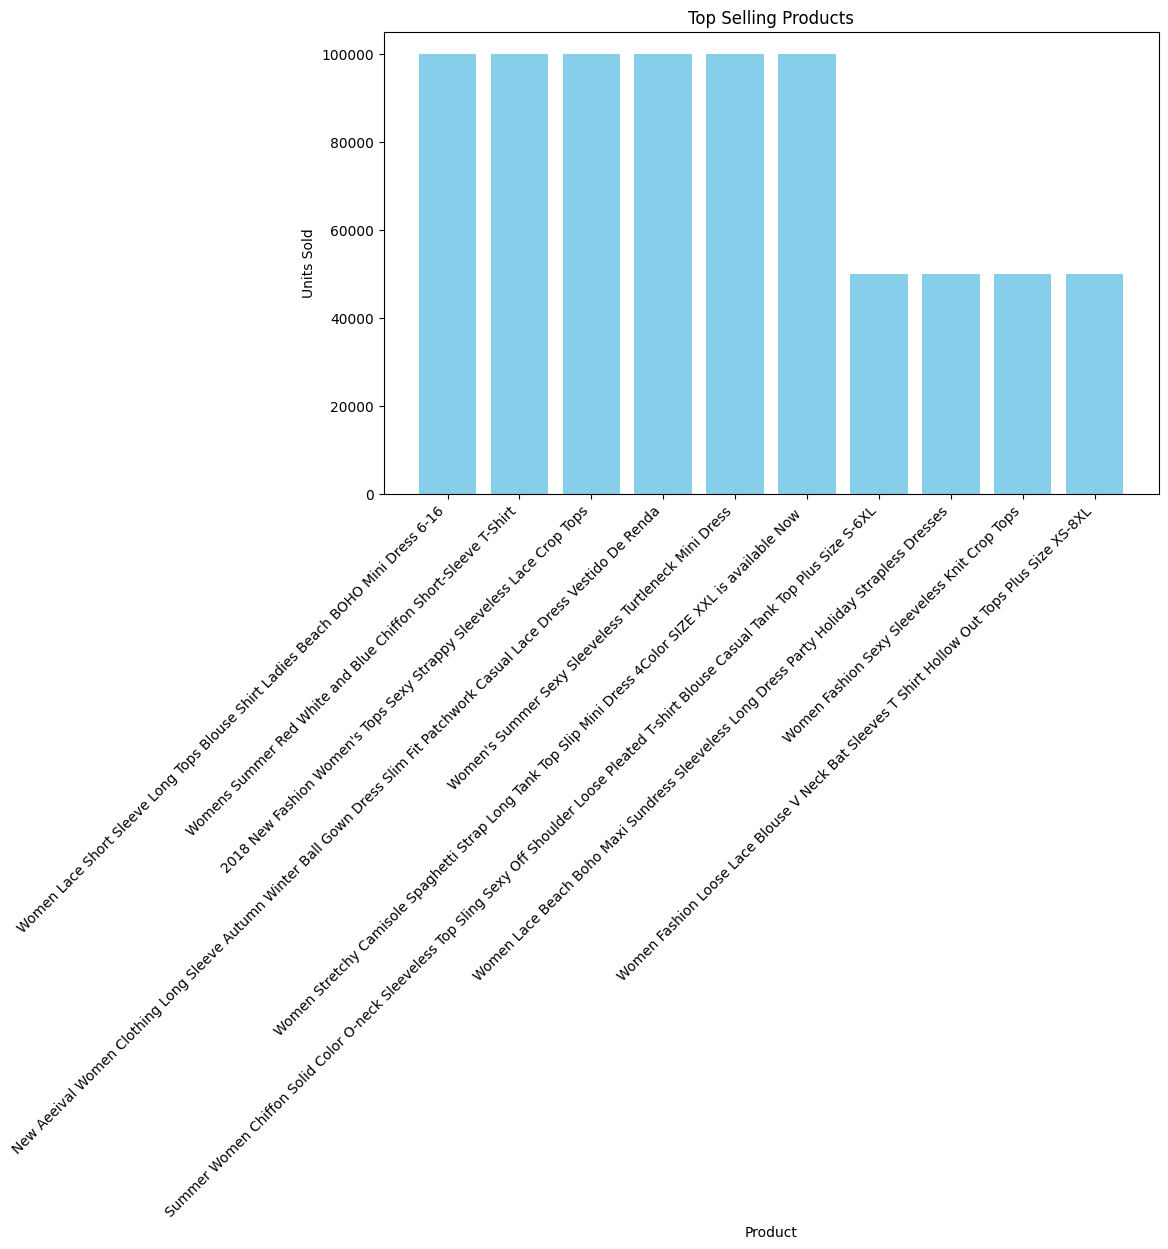

In [21]:
product_names = top_selling_products['title_orig']
units_sold = top_selling_products['units_sold']
# Create bar plot.
plt.figure(figsize=(10, 6))
plt.bar(product_names, units_sold, color='skyblue')
plt.xlabel('Product')
plt.ylabel('Units Sold')
plt.title('Top Selling Products')
plt.xticks(rotation=45, ha='right')
plt.show()

#### We decide that the top selling products have atleast 1000 sold products and have recieved a rating of atleast. We create a target variable to label the data for cache or not cache.

In [22]:
df['Cache'] = ((df['units_sold'] > 1000) | (df['rating'] > 4)).astype(int)
data = df

#### Beloware the shortlisted numerical and categorical features to train the model.

In [23]:
numerical_cols = ['price', 'retail_price', 'units_sold', 'rating', 'rating_count', 'shipping_option_price', 
'merchant_rating_count', 'merchant_rating', 'countries_shipped_to','uses_ad_boosts','shipping_is_express']
categorical_cols = ['product_color', 'product_variation_size_id']

In [24]:
data = data[numerical_cols + categorical_cols + ['Cache']]
data.head()

,price,retail_price,units_sold,rating,rating_count,shipping_option_price,merchant_rating_count,merchant_rating,countries_shipped_to,uses_ad_boosts,shipping_is_express,product_color,product_variation_size_id,Cache
0,16.00,14,100,3.76,54,4,568,4.128521,34,0,0,white,M,0
1,8.00,22,20000,3.45,6135,2,17752,3.899673,41,1,0,green,XS,1
2,8.00,43,100,3.57,14,3,295,3.989831,36,0,0,leopardprint,XS,0
3,8.00,8,5000,4.03,579,2,23832,4.020435,41,1,0,black,M,1
4,2.72,3,100,3.10,20,1,14482,4.001588,35,1,0,yellow,S,0


In [25]:
data = pd.get_dummies(data, columns=categorical_cols)
X = data.drop("Cache", axis=1)
y = data["Cache"]

In [26]:
print(data.columns)

Index(['price', 'retail_price', 'units_sold', 'rating', 'rating_count',
       'shipping_option_price', 'merchant_rating_count', 'merchant_rating',
       'countries_shipped_to', 'uses_ad_boosts',
       ...
       'product_variation_size_id_XXXL', 'product_variation_size_id_XXXS',
       'product_variation_size_id_XXXXL', 'product_variation_size_id_XXXXXL',
       'product_variation_size_id_choose a size',
       'product_variation_size_id_daughter 24M',
       'product_variation_size_id_first  generation',
       'product_variation_size_id_pants-S', 'product_variation_size_id_s',
       'product_variation_size_id_size S'],
      dtype='object', length=219)


#### This block splits our dataset into training and testing sets using the train_test_split function. We reserve 20% of the data for testing while the rest is used for training. The parameter random_state ensures reproducibility of the split. Here, we initialize four different classification models: Logistic Regression, Random Forest, Decision Tree, and Support Vector Machine (SVM). We then train each model using the fit method with the training data. In this block, we make predictions on the test set using each trained model (predict method). We then compute accuracy scores for each model by comparing the predicted labels with the true labels using accuracy_score.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
log_reg = LogisticRegression(max_iter=1000000, random_state=42)
random_forest = RandomForestClassifier(random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
svm_classifier = SVC(random_state=42)
#
log_reg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
#
y_pred_log_reg = log_reg.predict(X_test)
y_pred_random_forest = random_forest.predict(X_test)
y_pred_decision_tree = decision_tree.predict(X_test)
y_pred_svm = svm_classifier.predict(X_test)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Logistic Regression Accuracy:", accuracy_log_reg)
print("Random Forest Accuracy:", accuracy_random_forest)
print("SVM Accuracy:", accuracy_svm)

Logistic Regression Accuracy: 0.9301587301587302
Random Forest Accuracy: 0.9968253968253968
SVM Accuracy: 0.7301587301587301


#### This code block generates a comparison plot of the accuracy scores achieved by each model. It visualizes the performance of different models, making it easier to interpret their relative effectiveness.

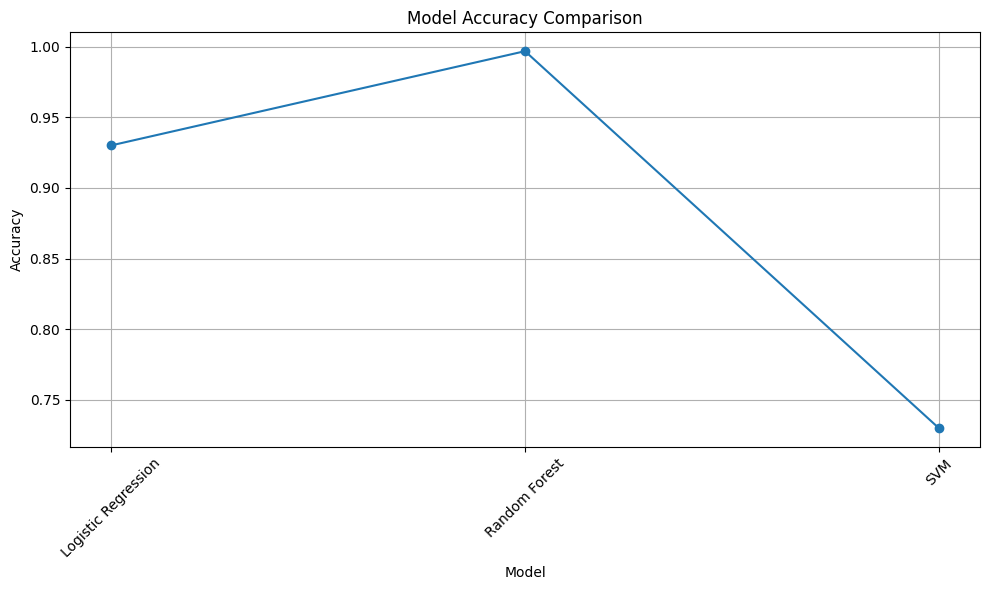

In [29]:
# List of model names.
models = ['Logistic Regression', 'Random Forest','SVM']
# List of accuracy scores.
accuracies = [accuracy_log_reg, accuracy_random_forest, accuracy_svm]
# Create a line plot.
plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o', linestyle='-')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Show the plot.
plt.show()


#### The models may be overfitting as the data sample is very small. Improving data quality, size and hyper parameter tuning will help make better models. This is a basic implemenation to judge if the searched product needs to be stored in Redis cache. 

In [30]:
df.columns

Index(['title', 'title_orig', 'price', 'retail_price', 'currency_buyer',
       'units_sold', 'uses_ad_boosts', 'rating', 'rating_count',
       'rating_five_count', 'rating_four_count', 'rating_three_count',
       'rating_two_count', 'rating_one_count', 'badges_count',
       'badge_local_product', 'badge_product_quality', 'badge_fast_shipping',
       'tags', 'product_color', 'product_variation_size_id',
       'product_variation_inventory', 'shipping_option_name',
       'shipping_option_price', 'shipping_is_express', 'countries_shipped_to',
       'inventory_total', 'has_urgency_banner', 'urgency_text',
       'origin_country', 'merchant_title', 'merchant_name',
       'merchant_info_subtitle', 'merchant_rating_count', 'merchant_rating',
       'merchant_id', 'merchant_has_profile_picture',
       'merchant_profile_picture', 'product_url', 'product_picture',
       'product_id', 'theme', 'crawl_month', 'Cache'],
      dtype='object')

#### This final block defines an example instance of new data (a product) and prepares it for prediction. After preprocessing the data, it uses the trained Random Forest model to predict whether the data should be stored in a cache. The result of the prediction is printed accordingly.

In [31]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)
example_instance = {
    'price': [16.00],
    'retail_price': [14],
    'units_sold': [100],
    'rating': [3.76],
    'rating_count': [54],
    'shipping_option_price': [4],
    'merchant_rating_count': [568],
    'merchant_rating': [4.128521],
    'countries_shipped_to': [34],
    'uses_ad_boosts': [0],
    'product_color': ['white'],
    'product_variation_size_id': ['M'],
    'shipping_is_express': [0]
}
# Convert the example instance into a DataFrame.
example_data = pd.DataFrame(example_instance)
# Convert categorical variables into dummy variables.
example_data = pd.get_dummies(example_data, columns=['product_color', 'product_variation_size_id'])
# Ensure all columns are present and in the same order as the training data.
missing_cols = list(set(X_train.columns) - set(example_data.columns))
for col in missing_cols:
    example_data[col] = 0
# Reorder the columns to match the order of features in the training data.
example_data = example_data[X_train.columns]
# Make predictions on the example data.
predictions = random_forest.predict(example_data)

/tmp/ipykernel_26/2867735392.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  example_data[col] = 0
/tmp/ipykernel_26/2867735392.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  example_data[col] = 0
/tmp/ipykernel_26/2867735392.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  example_dat

In [32]:
# Print if the data should be stored in Redis or not based on the prediction.
if predictions[0] == 1:
    print("Predicting if the data is important enough to be stored in redis for caching: Store data in Redis.")
else:
    print("Predicting if the data is important enough to be stored in redis for caching: Do not store data in Redis.")

Predicting if the data is important enough to be stored in redis for caching: Do not store data in Redis.


#### Here we predicted if the example data should be stored in redis for caching using random forest classifier. It should be directly retrieved from Mongo if the user asks and not store for caching. This is an important feature as we are optimizing the memory of Redis. Thus the system will decide if the data called by user should be stored in Redis. In the above instance even if the user calls the data multiple times, the system will fetch it from Mongo and not redis.